# UniLEAF Experiment

Exported UniLEAF run.

In [2]:
# Uncomment the following lines and execute the cell to install this notebook's dependencies.
# You might need to restart the notebook's kernel.

# %pip install leaf_common-1.2.1-py3-none-any.whl
# %pip install esp_sdk-3.2.0-py3-none-any.whl
# %pip install unileaf_util-0.2.2-py3-none-any.whl


In [3]:
import numbers
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from abc import ABC
from abc import abstractmethod
from io import StringIO
from pandas.api.types import is_numeric_dtype
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple
from typing import Type
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time

import xarray as xr
import regionmask

from leaf_common.candidates.representation_types import RepresentationType
from leaf_common.representation.rule_based.config.rule_set_config_helper import RuleSetConfigHelper
from leaf_common.representation.rule_based.data.features import Features
from leaf_common.representation.rule_based.data.rule_set import RuleSet
from leaf_common.representation.rule_based.data.rule_set_binding import RuleSetBinding
from leaf_common.representation.rule_based.evaluation.rule_set_binding_evaluator import RuleSetBindingEvaluator
from leaf_common.representation.rule_based.persistence.rule_set_file_persistence import RuleSetFilePersistence
from esp_sdk.esp_evaluator import EspEvaluator
from esp_sdk.esp_service import EspService
from unileaf_util.framework.interfaces.data_frame_predictor import DataFramePredictor
from unileaf_util.framework.metrics.metrics_manager import MetricsManager
from unileaf_util.framework.transformers.data_encoder import DataEncoder

pd.set_option('display.max_columns', None)

In [4]:
LAND_USE_COLS = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per', 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban']
CONTEXT_COLUMNS = LAND_USE_COLS +  ['cell_area']
DIFF_LAND_USE_COLS = [f"{col}_diff" for col in LAND_USE_COLS]
COLS_MAP = dict(zip(LAND_USE_COLS, DIFF_LAND_USE_COLS))

RECO_COLS = ['c3ann', 'c3nfx', 'c3per','c4ann', 'pastr', 'range', 'secdf', 'secdn']
DIFF_RECO_COLS = [f"{col}_diff" for col in RECO_COLS]
RECO_MAP = dict(zip(RECO_COLS, DIFF_RECO_COLS))
NO_CHANGE_COLS = ["c4per_diff", "primf_diff", "primn_diff", "urban_diff"]

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries_df = countries.to_dataframe()

EU_COUNTRIES = ["GB", "FR", "DE", "NL", "BE", "CH", "IE"]
# ["Brazil", "Bolivia", "Paraguay", "Peru", "Ecuador", "Colombia", "Venezuela", "Guyana", "Suriname", "Uruguay", "Argentina", "Chile"]
SA_COUNTRIES = ["BR", "BO", "PY", "PE", "EC", "CO", "VE", "GY", "SR", "UY", "AR", "CL"]
US_COUNTRIES = ["US"]
COUNTRY_DICT = {"EU": EU_COUNTRIES, "SA": SA_COUNTRIES, "US": US_COUNTRIES, "ALL": None}

# For pytorch training
device = "mps"

MANUAL_MAP = {
    "INDO": 360,
    "DRC": 180,
    "RUS": 643,
    "N": 578,
    "F": 250,
    "J": 388,
    "NA": 516,
    "PAL": 275,
    "J": 400,
    "IRQ": 368,
    "IND": 356,
    "IRN": 364,
    "SYR": 760,
    "ARM": 51,
    "S": 752,
    "A": 36,
    "EST": 233,
    "D": 276,
    "L": 442,
    "B": 56,
    "P": 620,
    "E": 724,
    "IRL": 372,
    "I": 380,
    "SLO": 705,
    "FIN": 246,
    "J": 392,
    "BiH": 70,
    "NM": 807,
    "KO": 383,
    "SS": 728
}

codes_df = pd.read_csv("../../mvp/data/gcb/conversion/codes.csv")

# Replace all the bad codes with their real ones
for i in range(len(countries_df)):
    old_abbrev = countries_df.iloc[i]["abbrevs"]
    if old_abbrev in MANUAL_MAP.keys() and MANUAL_MAP[old_abbrev] in codes_df["Numeric code"].unique():
        countries_df.iloc[i]["abbrevs"] = codes_df[codes_df["Numeric code"] == MANUAL_MAP[old_abbrev]]["Alpha-2 code"].iloc[0]

### Parameters to change

In [5]:
START_YEAR = 1851
TEST_YEAR = 2012
EVAL_PCT = 0.001
COUNTRIES = None
TRAIN_ZONES = ["EU", "US", "SA", "ALL"]

EXPERIMENT_ID = "NN"
EXPERIMENT_VERSION = "better_nn_noc4per"
TEMPLATE_PATH = "template_prescriptors/no_c4per/1_1.h5"
SEED_DIR = "/Users/964840/workspace/resilience/leaf/seed_weights_dir/one_min_max_noc4per/"
MODEL_TYPE = "nn"

In [6]:
config = {
    'evolution': {
        'fitness': [
            {'maximize': False, 'metric_name': 'ELUC'},
            {'maximize': False, 'metric_name': 'change'}
        ],
        'nb_elites': 10,
        'mutation_type': 'gaussian_noise_percentage',
        'nb_generations': 100,
        'mutation_factor': 0.2,
        'population_size': 100,
        'parent_selection': 'tournament',
        'initialization_range': 1,
        'mutation_probability': 0.2,
        'remove_population_pct': 0.8,
        'initialization_distribution': 'orthogonal',
        'seed_weights_dir': SEED_DIR
    },
    'network': {
        'inputs': [
            {'name': 'c3ann', 'size': 1, 'values': ['float']}, 
            {'name': 'c3nfx', 'size': 1, 'values': ['float']}, 
            {'name': 'c3per', 'size': 1, 'values': ['float']}, 
            {'name': 'c4ann', 'size': 1, 'values': ['float']}, 
            {'name': 'c4per', 'size': 1, 'values': ['float']}, 
            {'name': 'pastr', 'size': 1, 'values': ['float']}, 
            {'name': 'primf', 'size': 1, 'values': ['float']}, 
            {'name': 'primn', 'size': 1, 'values': ['float']}, 
            {'name': 'range', 'size': 1, 'values': ['float']}, 
            {'name': 'secdf', 'size': 1, 'values': ['float']}, 
            {'name': 'secdn', 'size': 1, 'values': ['float']}, 
            {'name': 'urban', 'size': 1, 'values': ['float']}, 
            {'name': 'cell_area', 'size': 1, 'values': ['float']}
      ],
      'outputs': [
          {'name': 'reco_land_use', 'size': len(RECO_COLS), 'activation': 'softmax', 'use_bias': True, 'values': ['float']}
      ],
      'hidden_layers': [
          {'layer_name': 'hidden_1', 'layer_type': 'Dense', 'layer_params': {'units': 16, 'use_bias': True, 'activation': 'tanh'}}
      ]
    },
    'LEAF': {
        'representation': 'NNWeights',
        'experiment_id': EXPERIMENT_ID,
        'version': EXPERIMENT_VERSION,
        'persistence_dir': 'trained_prescriptors/',
        'candidates_to_persist': 'pareto',
        'esp_host': "localhost",
        'esp_port': "50051",
        'secure': False
    }
}

## Load the dataset

In [7]:
def import_data(path, update_path):
    raw = xr.open_zarr(path, consolidated=True)

    # Get updated ELUC
    if update_path:
        eluc = xr.open_dataset(update_path)
        raw = raw.drop_vars(["ELUC", "cell_area"])
        raw = raw.merge(eluc)

    # Shift actions back a year
    raw[DIFF_LAND_USE_COLS] = raw[DIFF_LAND_USE_COLS].shift(time=-1)

    # Old time shifting
    # raw['ELUC'] = raw['ELUC'].shift(time=1)
    # raw['ELUC_diff'] = raw['ELUC_diff'].shift(time=1)
    # raw['time'] = raw.time - 1
    # assert(list(np.unique(raw.time)) == list(range(1849, 2022)))
    # mask = raw["ELUC_diff"].isnull().compute()
    # raw = raw.where(~mask, drop=True)

    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(raw)
    raw["country"] = country_mask
    return raw

def subset_countries(df, countries):
    """
    Subsets dataframe by country list
    """
    if countries:
        idx = countries_df[countries_df["abbrevs"].isin(countries)].index.values
        return df[df["country"].isin(idx)].copy()
    return df.copy()

def da_to_df(da, start_year=None, end_year=None, countries=None):
    df = da.to_dataframe()
    df = df.dropna()
    df = df.reorder_levels(["time", "lat", "lon"]).sort_index()
    df['country_name'] = countries_df.loc[df['country'], 'names'].values
    if start_year:
        df = df.loc[start_year:]
    if end_year:
        df = df.loc[:end_year]
    if countries:
        df = subset_countries(df, countries)
        
    return df

In [8]:
# DATASET_CSV = "../data/gbfdnlbchirl_1982_new2.csv"
# with open(DATASET_CSV) as df_file:
#     data_source_df = pd.read_csv(df_file)
DATA_FILE_PATH = "../../mvp/data/gcb/merged_aggregated_dataset_1850_2022.zarr.zip"
UPDATE_FILE_PATH = "../../mvp/data/gcb/BLUE_LUH2-GCB2022_ELUC-committed_gridded_net_1850-2021.nc"
raw = import_data(DATA_FILE_PATH, UPDATE_FILE_PATH)
data_source_df = da_to_df(raw, start_year=START_YEAR, end_year=TEST_YEAR, countries=COUNTRIES)

/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of c

In [9]:
print(data_source_df["country_name"].unique())

['Chile' 'Argentina' 'Falkland Is.' 'Fr. S. Antarctic Lands' 'New Zealand'
 'Australia' 'Uruguay' 'South Africa' 'Brazil' 'Lesotho' 'Namibia'
 'Paraguay' 'eSwatini' 'Botswana' 'Mozambique' 'Madagascar' 'Bolivia'
 'Zimbabwe' 'New Caledonia' 'Peru' 'Fiji' 'Angola' 'Zambia' 'Malawi'
 'Vanuatu' 'Dem. Rep. Congo' 'Tanzania' 'Papua New Guinea' 'Solomon Is.'
 'Indonesia' 'Timor-Leste' 'Ecuador' 'Congo' 'Burundi' 'Kenya' 'Colombia'
 'Gabon' 'Rwanda' 'Uganda' 'Somalia' 'Venezuela' 'Malaysia' 'Eq. Guinea'
 'Guyana' 'Suriname' 'Cameroon' 'France' 'Central African Rep.' 'S. Sudan'
 'Ethiopia' 'Brunei' "Côte d'Ivoire" 'Nigeria' 'Liberia' 'Ghana'
 'Philippines' 'Thailand' 'Togo' 'Sri Lanka' 'Benin' 'Sierra Leone'
 'Panama' 'Guinea' 'Chad' 'Somaliland' 'Costa Rica' 'Sudan' 'Vietnam'
 'India' 'Burkina Faso' 'Trinidad and Tobago' 'Myanmar' 'Mali' 'Cambodia'
 'Nicaragua' 'Guinea-Bissau' 'Djibouti' 'Niger' 'Senegal' 'Eritrea'
 'Yemen' 'Honduras' 'El Salvador' 'Gambia' 'Guatemala' 'Laos' 'Mexico'
 'Maurit

In [10]:
data_source_df.describe()

,ELUC_diff,c3ann,c3ann_diff,c3nfx,c3nfx_diff,c3per,c3per_diff,c4ann,c4ann_diff,c4per,c4per_diff,cell_area_diff,mask,pastr,pastr_diff,primf,primf_diff,primn,primn_diff,range,range_diff,secdf,secdf_diff,secdn,secdn_diff,urban,urban_diff,ELUC,cell_area,country
count,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07,3.920967e+07
mean,1.293274e-04,4.671951e-02,1.845145e-04,9.442559e-03,5.691163e-05,4.708876e-03,3.065203e-05,1.205987e-02,7.015613e-05,6.194019e-04,5.605164e-06,5.477159e+04,1.000000e+00,2.829698e-02,1.819324e-04,2.392176e-01,-7.773910e-04,3.239423e-01,-1.098077e-03,1.132091e-01,6.103809e-04,7.431429e-02,5.049623e-04,7.400460e-02,2.055430e-04,1.488011e-03,2.480968e-05,8.134831e-02,5.477159e+04,5.246186e+01
std,1.463533e-01,1.171473e-01,2.368809e-03,3.468952e-02,6.807328e-04,1.990552e-02,5.000681e-04,4.089984e-02,1.118762e-03,6.318484e-03,1.629234e-04,1.843773e+04,5.960464e-08,8.388362e-02,3.426221e-03,3.842906e-01,3.290688e-03,3.891261e-01,4.059673e-03,2.244995e-01,7.341694e-03,1.987301e-01,3.580259e-03,1.858098e-01,6.178441e-03,1.564418e-02,4.551453e-04,5.119691e-01,1.843773e+04,5.363478e+01
min,-3.699325e+01,0.000000e+00,-7.095690e-01,0.000000e+00,-9.209770e-02,0.000000e+00,-1.348705e-01,0.000000e+00,-2.498624e-01,0.000000e+00,-8.055314e-02,8.915479e+03,1.000000e+00,0.000000e+00,-7.643555e-01,0.000000e+00,-8.508436e-01,0.000000e+00,-9.365569e-01,0.000000e+00,-9.993974e-01,0.000000e+00,-5.746354e-01,0.000000e+00,-9.999263e-01,0.000000e+00,-1.509361e-01,-8.890611e+01,8.915479e+03,0.000000e+00
25%,-7.660943e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.907563e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.384186e-07,0.000000e+00,-3.775358e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.907563e+04,1.100000e+01
50%,0.000000e+00,2.695671e-05,0.000000e+00,5.516298e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.865218e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.581477e-02,0.000000e+00,5.155206e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.865218e+04,2.200000e+01
75%,2.374649e-04,1.787356e-02,2.774061e-05,2.221474e-03,2.539309e-06,4.558641e-04,9.208601e-08,2.510154e-03,2.218650e-06,0.000000e+00,0.000000e+00,7.158655e+04,1.000000e+00,3.184252e-04,0.000000e+00,4.476053e-01,0.000000e+00,6.847097e-01,0.000000e+00,9.370922e-02,1.788548e-04,2.518357e-03,0.000000e+00,2.683721e-02,0.000000e+00,0.000000e+00,0.000000e+00,5.116987e-02,7.158655e+04,9.800000e+01
max,6.850004e+01,9.522417e-01,7.314107e-01,6.590130e-01,1.364622e-01,6.860708e-01,1.232214e-01,9.358039e-01,1.760741e-01,7.032631e-01,6.793208e-02,7.727670e+04,1.000000e+00,1.000000e+00,7.259913e-01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.250281e-01,1.000000e+00,9.993974e-01,1.000000e+00,1.676578e-01,1.169540e+02,7.727670e+04,1.760000e+02


## Encode the dataset
Encode the dataset using the fields definition from the Experiment's data source

In [11]:
#fields = {'ELUC': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.11856405, 'range': [-38.421227, 22.764368], 'std_dev': 1.0573674, 'sum': -54801.844, 'valued': 'CONTINUOUS'}, 'c3ann': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.26532868, 'range': [0, 0.9289606], 'std_dev': 0.16872787, 'sum': 122638.36, 'valued': 'CONTINUOUS'}, 'c3nfx': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.015724484, 'range': [0, 0.09423922], 'std_dev': 0.013063688, 'sum': 7268.061, 'valued': 'CONTINUOUS'}, 'c3per': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.013562751, 'range': [0, 0.37380314], 'std_dev': 0.030480456, 'sum': 6268.88, 'valued': 'CONTINUOUS'}, 'c4ann': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.047797143, 'range': [0, 0.44018674], 'std_dev': 0.04781523, 'sum': 22092.46, 'valued': 'CONTINUOUS'}, 'c4per': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 1.8471316e-09, 'range': [0, 2.1909951e-05], 'std_dev': 9.993674e-08, 'sum': 0.00085376826, 'valued': 'CONTINUOUS'}, 'pastr': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.2755411, 'range': [0, 0.9999977], 'std_dev': 0.18394634, 'sum': 127358.67, 'valued': 'CONTINUOUS'}, 'primf': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.0408774, 'range': [0, 1], 'std_dev': 0.19624169, 'sum': 18894.066, 'valued': 'CONTINUOUS'}, 'primn': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.0010933084, 'range': [0, 0.81347555], 'std_dev': 0.023737159, 'sum': 505.3414, 'valued': 'CONTINUOUS'}, 'range': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.015515061, 'range': [0, 0.76993644], 'std_dev': 0.064742275, 'sum': 7171.2627, 'valued': 'CONTINUOUS'}, 'secdf': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.12541063, 'range': [0, 1], 'std_dev': 0.2203229, 'sum': 57966.426, 'valued': 'CONTINUOUS'}, 'secdn': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.14883429, 'range': [0, 0.9977025], 'std_dev': 0.2135971, 'sum': 68793.15, 'valued': 'CONTINUOUS'}, 'urban': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.023921186, 'range': [0, 0.9804862], 'std_dev': 0.0599659, 'sum': 11056.683, 'valued': 'CONTINUOUS'}, 'change': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.004188048, 'range': [0, 0.3609924], 'std_dev': 0.009503605, 'sum': 1935.7703, 'valued': 'CONTINUOUS'}, 'cell_area': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 50892.78, 'range': [40233.22, 77223.74], 'std_dev': 6527.7935, 'sum': 23523305000, 'valued': 'CONTINUOUS'}, 'c3ann_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.00044108444, 'range': [-0.28561932, 0.09917167], 'std_dev': 0.0037445952, 'sum': -203.87495, 'valued': 'CONTINUOUS'}, 'c3nfx_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -2.9746114e-05, 'range': [-0.015432712, 0.014108786], 'std_dev': 0.00022670913, 'sum': -13.749041, 'valued': 'CONTINUOUS'}, 'c3per_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -2.4286626e-05, 'range': [-0.02339302, 0.022070948], 'std_dev': 0.0003331531, 'sum': -11.2255945, 'valued': 'CONTINUOUS'}, 'c4ann_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -7.317337e-05, 'range': [-0.054494824, 0.05511633], 'std_dev': 0.00080506655, 'sum': -33.821682, 'valued': 'CONTINUOUS'}, 'c4per_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 3.2219023e-11, 'range': [-1.3854105e-06, 8.639275e-06], 'std_dev': 1.55411e-08, 'sum': 1.4892052e-05, 'valued': 'CONTINUOUS'}, 'pastr_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -0.00056610367, 'range': [-0.3609924, 0.13539696], 'std_dev': 0.008346922, 'sum': -261.6605, 'valued': 'CONTINUOUS'}, 'primf_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -9.644197e-06, 'range': [-0.014856517, 0], 'std_dev': 0.00010567804, 'sum': -4.4576735, 'valued': 'CONTINUOUS'}, 'primn_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': -1.4477387e-06, 'range': [-0.046862364, 0], 'std_dev': 9.3433555e-05, 'sum': -0.66916364, 'valued': 'CONTINUOUS'}, 'range_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 5.9423666e-05, 'range': [-0.16614735, 0.16141176], 'std_dev': 0.0032823936, 'sum': 27.46639, 'valued': 'CONTINUOUS'}, 'secdf_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00023636929, 'range': [-0.17319721, 0.35972273], 'std_dev': 0.0065409928, 'sum': 109.25296, 'valued': 'CONTINUOUS'}, 'secdn_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.0006134256, 'range': [-0.1592417, 0.3085313], 'std_dev': 0.0069925156, 'sum': 283.5333, 'valued': 'CONTINUOUS'}, 'urban_diff': {'data_type': 'FLOAT', 'has_nan': False, 'mean': 0.00023626754, 'range': [-0.034920335, 0.11945325], 'std_dev': 0.000924528, 'sum': 109.20593, 'valued': 'CONTINUOUS'}}
fields = dict()
for col in LAND_USE_COLS + DIFF_LAND_USE_COLS + ["cell_area", "ELUC"]:
    if col in LAND_USE_COLS:
        ran = [0, 1]
    elif col in DIFF_LAND_USE_COLS:
        ran = [-1, 1]
    else:
        ran = [data_source_df[col].min(), data_source_df[col].max()]
    fields[col] = {
        "data_type": "FLOAT",
        "has_nan": False,
        "mean": data_source_df[col].mean(),
        "range": ran,
        "std_dev": data_source_df[col].std(),
        "sum": data_source_df[col].sum(),
        "valued": "CONTINUOUS"
    }

# TODO: This is just dummy values. Will it work?
fields["change"] = {
    "data_type": "FLOAT",
    "has_nan": False,
    "mean": 0.5,
    "range": [0, 1],
    "std_dev": 0.1,
    "sum": len(data_source_df) // 2,
    "valued": "CONTINUOUS"
}

In [12]:
import IPython.display
IPython.display.JSON(fields)

<IPython.core.display.JSON object>

In [13]:
cao_mapping = {'context': ['c3ann', 'c3nfx', 'c3per', 'c4ann', 'c4per', 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area'], 'actions': ['c3ann_diff', 'c3nfx_diff', 'c3per_diff', 'c4ann_diff', 'c4per_diff', 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff'], 'outcomes': ['ELUC', 'change']}

In [14]:
import IPython.display
IPython.display.JSON(cao_mapping)

<IPython.core.display.JSON object>

In [15]:
encoder = DataEncoder(fields, cao_mapping)
encoded_data_source_df = encoder.encode_as_df(data_source_df)
encoded_data_source_df.head()

,c3ann,c3ann_diff,c3nfx,c3nfx_diff,c3per,c3per_diff,c4ann,c4ann_diff,c4per,c4per_diff,pastr,pastr_diff,primf,primf_diff,primn,primn_diff,range,range_diff,secdf,secdf_diff,secdn,secdn_diff,urban,urban_diff,ELUC,cell_area
0,1.529372e-07,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.0,0.5,0.0,0.5,0.659071,0.499948,0.000000,0.5,0.000019,0.5,0.012612,0.500052,0.000000,0.5,0.0,0.5,0.431897,0.511891
1,6.256299e-08,0.5,8.209591e-09,0.5,1.742937e-08,0.5,8.359032e-09,0.5,0.0,0.5,0.0,0.5,0.087628,0.500000,0.000000,0.5,0.000018,0.5,0.001253,0.500000,0.000000,0.5,0.0,0.5,0.431876,0.511891
2,2.541674e-08,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.0,0.5,0.0,0.5,0.000000,0.500000,0.591408,0.5,0.000015,0.5,0.000000,0.500000,0.000034,0.5,0.0,0.5,0.431876,0.511891
3,6.788947e-08,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.0,0.5,0.0,0.5,0.000000,0.500000,0.730712,0.5,0.000017,0.5,0.000000,0.500000,0.000038,0.5,0.0,0.5,0.431876,0.511891
4,1.061018e-06,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.000000e+00,0.5,0.0,0.5,0.0,0.5,0.000000,0.500000,0.756431,0.5,0.000019,0.5,0.000000,0.500000,0.000044,0.5,0.0,0.5,0.431876,0.511891


## Predictor code

In [16]:
REGRESSOR = 'regressor'
CLASSIFIER = 'classifier'
TYPES = [REGRESSOR, CLASSIFIER]
predictors_by_id = {}

## Predictor a1a25d68-bb9f-ff0c-c3b9-395329ccb622
### CAO columns

## Predictor

### Ensemble Predictor

In [17]:
class SuperPredictor():
    def __init__(self, dataframes, model_type, features, label):
        """
        dataframes: a list of dataframes to train on.
        """
        self.models = []
        self.features = features
        self.label = label
        for df in dataframes:
            if model_type == "linreg":
                model = linear_model.LinearRegression()
            else:
                model = RandomForestRegressor(n_jobs=-1)
            model.fit(df[features], df[label])
            self.models.append(model)

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        X: a dataframe to predict on
        """
        preds = []
        for model in self.models:
            preds.append(model.predict(X[self.features]))
        preds_np = np.stack(preds, axis=0)
        avgs = preds_np.mean(axis=0)
        return pd.DataFrame(data=avgs, columns=[self.label])
    
    def get_coefs(self):
        sum = np.zeros(len(DIFF_LAND_USE_COLS))
        for model in self.models:
            sum += model.coef_
        sum /= len(self.models)
        return sum

In [18]:
dataframes = []
for zone in TRAIN_ZONES:
    countries = COUNTRY_DICT[zone]
    df_zone = subset_countries(data_source_df, countries)
    dataframes.append(df_zone)

superpredictor = SuperPredictor(dataframes, "linreg", DIFF_LAND_USE_COLS, "ELUC")
print(superpredictor.get_coefs())

[ 84.31348705  66.48178291 103.05984467  58.71910763 415.25870705
  39.01834702 -92.33775902   5.00574125  17.09175977 -51.11251616
  -6.10263056  39.4406805 ]


### Neural Net Predictor

In [19]:
class NeuralNet():

    class CustomDS(Dataset):
        def __init__(self, X_train, y_train):
            super().__init__()   
            self.X = torch.tensor(X_train, dtype=torch.float32)
            self.y = torch.tensor(y_train)

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]


    class ELUCNeuralNet(torch.nn.Module):

        class EncBlock(torch.nn.Module):
            def __init__(self, in_size, out_size, dropout):
                super().__init__()
                self.model = torch.nn.Sequential(
                    torch.nn.Linear(in_size, out_size),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=dropout)
                )
            def forward(self, X):
                return self.model(X)

        def __init__(self, in_size, hidden_sizes, linear_skip, dropout):
            super().__init__()
            self.linear_skip = linear_skip
            hidden_sizes = [in_size] + hidden_sizes
            enc_blocks = [self.EncBlock(hidden_sizes[i], hidden_sizes[i+1], dropout) for i in range(len(hidden_sizes) - 1)]
            self.enc = torch.nn.Sequential(*enc_blocks)
            out_size = hidden_sizes[-1] + in_size if linear_skip else hidden_sizes[-1]
            self.linear = torch.nn.Linear(out_size, 1)

        def forward(self, X):
            hid = self.enc(X)
            if self.linear_skip:
                hid = torch.concatenate([hid, X], dim=1)
            out = self.linear(hid)
            return out


    def __init__(self, in_size, hidden_sizes, linear_skip=False, dropout=0, device="mps"): 
        # Model
        self.model = self.ELUCNeuralNet(in_size, hidden_sizes, linear_skip, dropout)
        self.model.to(device)
        self.device = device

    def load_from_state_dict(self, state_dict_path):
        self.model.load_state_dict(torch.load(state_dict_path))
        self.model.eval()

    def fit(self, X_train, y_train, test=None, epochs=10, batch_size=2048, optim_params={}, train_pct=1, step_lr_params=None, save_path=None):
        s = time.time()
        train_ds = self.CustomDS(X_train, y_train)
        sampler = torch.utils.data.RandomSampler(train_ds, num_samples=int(len(train_ds) * train_pct))
        train_dl = DataLoader(train_ds, batch_size, sampler=sampler)

        test_dl = None
        if test:
            X_test, y_test = test
            test_ds = self.CustomDS(X_test, y_test)
            test_dl = DataLoader(test_ds, batch_size, shuffle=True)

        optimizer = torch.optim.AdamW(self.model.parameters(), **optim_params)
        loss_fn = torch.nn.L1Loss()
        if step_lr_params:
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **step_lr_params)

        best_model = None
        best_loss = np.inf
        best_epoch = 0

        step = 0
        test_step = 0
        for epoch in range(epochs):
            self.model.train()
            for X, y in tqdm(train_dl):
                X, y = X.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out = self.model(X).squeeze()
                loss = loss_fn(out, y)
                step += 1
                loss.backward()
                optimizer.step()
            
            # LR Decay
            if step_lr_params:
                scheduler.step()

            # Evaluate epoch
            if test_dl:
                total = 0
                self.model.eval()
                with torch.no_grad():
                    for X, y in tqdm(test_dl):
                        X, y = X.to(self.device), y.to(self.device)
                        out = self.model(X).squeeze()
                        loss = loss_fn(out, y)
                        test_step += 1
                        
                        total += loss.item() * y.shape[0]

                print(f"epoch {epoch} mae {total / len(test_ds)}")

        e = time.time()

        if save_path:
            if best_model:
                print(f"Saving best model epoch {best_epoch}")
                torch.save(best_model, save_path)
            else:
                print("Saving model...")
                torch.save(self.model.state_dict(), save_path)

        return e - s

    def predict(self, X_test):
        test_ds = self.CustomDS(X_test, np.zeros(len(X_test)))
        test_dl = DataLoader(test_ds, 2048, shuffle=False)
        pred_list = []
        with torch.no_grad():
            self.model.eval()
            for X, y in test_dl:
                X = X.to(self.device)
                pred_list.append(self.model(X).squeeze())
        
        y_pred = torch.concatenate(pred_list, dim=0).cpu().numpy()
        
        return y_pred

In [20]:
nn_feats = LAND_USE_COLS + ["cell_area"] + DIFF_LAND_USE_COLS
nn_params = {
    "in_size": len(nn_feats),
    "hidden_sizes": [4096],
    "dropout": 0,
    "linear_skip": True
}
net = NeuralNet(**nn_params)
# TODO: change this to match where the NN is saved from predictor_experiments.ipynb
NN_SAVE_PATH = "../saved/ALL-nn.pt"
net.load_from_state_dict(NN_SAVE_PATH)
scaler = StandardScaler()
scaler.fit(data_source_df[nn_feats])
net.model.to(device)
net.model.eval()

ELUCNeuralNet(
  (enc): Sequential(
    (0): EncBlock(
      (model): Sequential(
        (0): Linear(in_features=25, out_features=4096, bias=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=4121, out_features=1, bias=True)
)

## Prescriptor
### ESP credentials

In [21]:
esp_username = os.getenv('ESP_SERVICE_USER')
esp_password = os.getenv('ESP_SERVICE_PASSWORD')
if not esp_username or not esp_password:
    print('Please set environment variables before proceeding.')
else:
    print('ESP Service username and password found.')

ESP Service username and password found.


### Evaluation code

In [22]:
def reco_to_context_actions(reco_df, encoded_context_df, data_encoder):
    
    # This is gacky but has to happen sooner or later
    reco_df = reco_df.reset_index(drop=True)
    encoded_context_df = encoded_context_df.reset_index(drop=True)

    context_df = data_encoder.decode_as_df(encoded_context_df)

    # encoded_reco_df is just recommended proportions
    # Scale encoded_reco_df to context_df minus primf/primn
    # Multiply proportions by sum of non primn/primf cols
    reco_df = reco_df.mul(context_df[RECO_COLS].sum(axis=1), axis=0)

    # Compute the diff
    # Note: the index need to match in order to subtract. Otherwise we get NaN
    prescribed_actions_df = reco_df[RECO_COLS].reset_index(drop=True) - context_df[RECO_COLS].reset_index(drop=True)

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(RECO_MAP, axis=1)
    prescribed_actions_df[NO_CHANGE_COLS] = 0
    # Encode the diffs to match what the Predictor expects
    # Note: diffs are values between [-1, 1] and they are encoded between [0, 1]
    #encoded_prescribed_actions_df = data_encoder.encode_as_df(prescribed_actions_df[DIFF_RECO_COLS])
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df,
                                            prescribed_actions_df[DIFF_LAND_USE_COLS]],
                                            axis=1)
    
    return context_actions_df

In [23]:
class UnileafPrescriptor(EspEvaluator):
    """
    An Unileaf Prescriptor makes prescriptions given an ESP candidate and a context DataFrame.
    It is also an EspEvaluator implementation that returns metrics for ESP candidates.
    """

    def __init__(self,
                 config: Dict[str, Any],
                 evaluation_df: pd.DataFrame,
                 data_encoder: DataEncoder,
                 predictors):
        """
        Constructs a prescriptor evaluator
        :param config: the ESP experiment config dictionary
        :param evaluation_df: the encoded Pandas DataFrame to use to evaluate the candidates
        :param data_encoder: the DataEncoder used to encode the dataset
        :param predictors: the predictors this prescriptor relies on
        """
        # Instantiate EspEvaluator
        # Note: sets self.config
        super().__init__(config)

        # CAO
        self.cao_mapping = {"context": self.get_context_field_names(config),
                            "actions": self.get_action_field_names(config),
                            "outcomes": self.get_fitness_metrics(config)}
        self.context_df = evaluation_df[self.cao_mapping["context"]]
        self.row_index = self.context_df.index

        # Convert the context DataFrame to a format a NN can ingest
        self.context_as_nn_input = self.convert_to_nn_input(self.context_df)

        # Data encoder
        self.data_encoder = data_encoder

        # Predictors
        self.predictors = predictors

    @staticmethod
    def convert_to_nn_input(context_df: pd.DataFrame) -> List[np.ndarray]:
        """
        Converts a context DataFrame to a list of numpy arrays a neural network can ingest
        :param context_df: a DataFrame containing inputs for a neural network. Number of inputs and size must match
        :return: a list of numpy ndarray, on ndarray per neural network input
        """
        # The NN expects a list of i inputs by s samples (e.g. 9 x 299).
        # So convert the data frame to a numpy array (gives shape 299 x 9), transpose it (gives 9 x 299)
        # and convert to list(list of 9 arrays of 299)
        context_as_nn_input = list(context_df.to_numpy().transpose())
        # Convert each column's list of 1D array to a 2D array
        context_as_nn_input = [np.stack(context_as_nn_input[i], axis=0) for i in
                               range(len(context_as_nn_input))]
        return context_as_nn_input

    def evaluate_candidate(self, candidate):
        """
        Evaluates a single Prescriptor candidate and returns its metrics.
        Implements the EspEvaluator interface
        :param candidate: a Keras neural network or rule based Prescriptor candidate
        :return metrics: A dictionary of {'metric_name': metric_value}
        """
        # Save candidate to local file for easy debug
        # candidate.save('prescriptor.h5')
        
        # Prescribe actions
        # Single action, recommended percentage for each land use type
        # Note: prescribed action is a softmax, NOT encoded in the same scale as the context
        prescribed_actions_df = self.prescribe(candidate)
        
        # Convert the softmax into a DataFrame
        reco_land_use_df = pd.DataFrame(prescribed_actions_df["reco_land_use"].tolist(),
                                columns=RECO_COLS)
        
        context_actions_df = reco_to_context_actions(reco_land_use_df, self.context_df, self.data_encoder)

        # Compute the metrics
        metrics = self._compute_metrics(context_actions_df)
        return metrics
    
    def _compute_metrics(self, context_actions_df):
        """
        Computes metrics from the passed context/actions DataFrame using the instance's trained predictors.
        :param encoded_context_actions_df: a DataFrame of context / prescribed actions
        :return: A dictionary of {'metric_name': metric_value}
        """
        metrics = {}
        
        # Get the predicted ELUC from the predictors
        preds = self.predict_eluc(context_actions_df)
        metrics['ELUC'] = preds['ELUC'].mean()
        
        # Compute the % of change
        change_df = self.compute_percent_changed(context_actions_df)
        metrics['change'] = change_df['change'].mean()
        
        return metrics
    
    def predict_eluc(self, context_actions_df):
        predictor = self.predictors[0]
        # pred_array = []

        scaled_context_actions = scaler.transform(context_actions_df[nn_feats])

        # Decode inputs
        pred = predictor.predict(scaled_context_actions)
        # TODO: Was this necessary?
        # pred_array.append(pred)
        preds_df = pd.DataFrame(pred, columns=["ELUC"])
        preds_df = preds_df.astype("float64")
        return preds_df
    
    def compute_percent_changed(self, context_actions_df):

        context_actions_df = context_actions_df.reset_index(drop=True)
        # Decode in order to get the signed land usage diff values
        # context_action_df = encoder.decode_as_df(encoded_context_actions_df)
        
        # Sum the positive diffs
        percent_changed = context_actions_df[context_actions_df[DIFF_LAND_USE_COLS] > 0][DIFF_LAND_USE_COLS].sum(axis=1)
        # Land usage is only a portion of that cell, e.g 0.8. Scale back to 1
        # So that percent changed really represent the percentage of change within the land use
        # portion of the cell
        # I.e. how much of the pie chart has changed?
        percent_changed = percent_changed / context_actions_df[LAND_USE_COLS].sum(axis=1)
        df = pd.DataFrame(percent_changed, columns=['change'])
        return df

    def prescribe(self, candidate, context_df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Generates prescriptions using the passed candidate and context
        :param candidate: an ESP candidate, either neural network or rules
        :param context_df: a DataFrame containing the context to prescribe for,
         or None to use the instance one
        :return: a DataFrame containing actions prescribed for each context
        """
        if context_df is None:
            # No context is provided, use the instance's one
            context_as_nn_input = self.context_as_nn_input
            row_index = self.row_index
        else:
            # Convert the context DataFrame to something more suitable for neural networks
            context_as_nn_input = self.convert_to_nn_input(context_df)
            # Use the context's row index
            row_index = context_df.index

        is_rule_based = isinstance(candidate, RuleSet)
        if is_rule_based:
            actions = self._prescribe_from_rules(candidate, context_as_nn_input)
        else:
            actions = self._prescribe_from_nn(candidate, context_as_nn_input)

        # Convert the prescribed actions to a DataFrame
        prescribed_actions_df = pd.DataFrame(actions,
                                             columns=self.cao_mapping["actions"],
                                             index=row_index)
        return prescribed_actions_df

    def _prescribe_from_rules(self, candidate, context_as_nn_input: List[np.ndarray]):
        """
        Generates prescriptions using the passed rules model candidate and context
        :param candidate: a rules model candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to list of action values
        """
        cand_states = RuleSetConfigHelper.get_states(self.config)
        cand_actions = RuleSetConfigHelper.get_actions(self.config)
        candidate = RuleSetBinding(candidate, cand_states, cand_actions)
        rules_encoder = RulesDataEncoder(candidate.actions)
        evaluator = RuleSetBindingEvaluator()
        rules_input = rules_encoder.encode_to_rules_data(context_as_nn_input)
        rules_output = evaluator.evaluate(candidate, rules_input)
        actions = rules_encoder.decode_from_rules_data(rules_output)
        return actions

    def _prescribe_from_nn(self, candidate, context_as_nn_input: List[np.ndarray]) -> Dict[str, Any]:
        """
        Generates prescriptions using the passed neural network candidate and context
        :param candidate: a Keras neural network candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to action value or list of action values
        """
        # Get the prescribed actions
        prescribed_actions = candidate.predict(context_as_nn_input)
        actions = {}

        if self._is_single_action_prescriptor():
            # Put the single action in an array to process it like multiple actions
            prescribed_actions = [prescribed_actions]

        for i, action_col in enumerate(self.cao_mapping["actions"]):
            if self._is_scalar(prescribed_actions[i]):
                # We have a single row and this action is numerical. Convert it to a scalar.
                actions[action_col] = prescribed_actions[i].item()
            else:
                actions[action_col] = prescribed_actions[i].tolist()
        return actions

    def _is_single_action_prescriptor(self):
        """
        Checks how many Actions have been defined in the Context, Actions, Outcomes mapping.
        :return: True if only 1 action is defined, False otherwise
        """
        return len(self.cao_mapping["actions"]) == 1

    @staticmethod
    def _is_scalar(prescribed_action):
        """
        Checks if the prescribed action contains a single value, i.e. a scalar, or an array.
        A prescribed action contains a single value if it has been prescribed for a single context sample
        :param prescribed_action: a scalar or an array
        :return: True if the prescribed action contains a scalar, False otherwise.
        """
        return prescribed_action.shape[0] == 1 and prescribed_action.shape[1] == 1

    @staticmethod
    def get_context_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Context column names
        :param config: the ESP experiment config dictionary
        :return: the list of Context column names
        """
        nn_inputs = config["network"]["inputs"]
        contexts = [nn_input["name"] for nn_input in nn_inputs]
        return contexts

    @staticmethod
    def get_action_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Action column names
        :param config: the ESP experiment config dictionary
        :return: the list of Action column names
        """
        nn_outputs = config["network"]["outputs"]
        actions = [nn_output["name"] for nn_output in nn_outputs]
        return actions

    @staticmethod
    def get_fitness_metrics(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of fitness metric names (Outcomes) to optimize.
        :param config: the ESP experiment config dictionary
        :return: the list of fitness metric names
        """
        metrics = config["evolution"]["fitness"]
        fitness_metrics = [metric["metric_name"] for metric in metrics]
        return fitness_metrics


### Prescriptor training

In [24]:
import IPython.display
IPython.display.JSON(config)

<IPython.core.display.JSON object>

In [25]:
all_predictors = [net]

In [26]:
print(f"Original: {len(data_source_df)}")
eval_df = data_source_df.copy()
print(f"Eval: {len(eval_df)}")
eval_df = eval_df.sample(frac=EVAL_PCT, random_state=42)
print(f"Eval sample: {len(eval_df)}")
eval_df_encoded = encoder.encode_as_df(eval_df)

Original: 39209670
Eval: 39209670
Eval sample: 39210


### Seeding

In [27]:
import tensorflow as tf

# From ChatGPT
# Randomly initialize weights of model so that we can get different solutions
def create_randomized_model(base_model):
    randomized_model = tf.keras.models.clone_model(base_model)
    for layer in randomized_model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
        if hasattr(layer, 'bias_initializer'):
            layer.bias_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
    return randomized_model

def seed_no_change(data_df, encoded_data_df):
    # Get the proportions right
    land_use = data_df[RECO_COLS].sum(axis=1)
    # If we have 0 sum that means primf/n is 1 so we don't have to change anything in division
    land_use = land_use.replace(0, 1)
    no_change_preds = data_df[RECO_COLS].div(land_use, axis=0)

    y_train = no_change_preds.to_numpy()
    X_train = encoded_data_df[CONTEXT_COLUMNS].to_numpy().T
    X_train = [np.stack(X_train[i], axis=0) for i in range(len(X_train))]

    template = tf.keras.models.load_model(TEMPLATE_PATH, compile=False)

    no_change_model = create_randomized_model(template)

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    no_change_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])
    no_change_model.fit(X_train, y_train, epochs=100, batch_size=2**20, verbose=1)

    no_change_model.save(f"{SEED_DIR}/1_1.h5")

def seed_max_change(data_df, encoded_data_df):
    # Move all the land use to secdf
    print("dataing")
    land_use = data_df[RECO_COLS].sum(axis=1)
    max_change_preds = data_df[RECO_COLS].copy()
    max_change_preds[RECO_COLS] = 0
    max_change_preds["secdf"] = land_use

    y_train = max_change_preds.to_numpy()
    X_train = encoded_data_df[CONTEXT_COLUMNS].to_numpy().T
    X_train = [np.stack(X_train[i], axis=0) for i in range(len(X_train))]
    print("templating")
    template = tf.keras.models.load_model(TEMPLATE_PATH, compile=False)
    no_change_model = create_randomized_model(template)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    print("compiling")
    no_change_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])
    print("fitting")
    no_change_model.fit(X_train, y_train, epochs=100, batch_size=2**20, verbose=1)

    no_change_model.save(f"{SEED_DIR}/1_2.h5")


In [28]:
# TODO: Uncomment when you want to create new seed neural nets
# seed_max_change(eval_df, eval_df_encoded)
# seed_no_change(eval_df, eval_df_encoded)

### Prescription

In [60]:
# Instantiate the EspService
esp_service = EspService(config, esp_username, esp_password)
esp_evaluator = UnileafPrescriptor(config,
                                   eval_df_encoded,
                                   encoder,
                                   all_predictors)

ESP service: localhost:50051
gRPC options:
  grpc.max_send_message_length: 52428800
  grpc.max_receive_message_length: 52428800
Ready to connect.


In [34]:
# TODO: Uncomment this if you want to train
# experiment_results_dir = esp_service.train(esp_evaluator)

## ESP Summary Stats
esp_service.train(...) returned the directory in which the experiment results are stored

In [29]:
import json
# TODO: Change this to match your run
experiment_results_dir = f"trained_prescriptors/NN/better_nn_noc4per/"
config = json.load(open(f"{experiment_results_dir}/experiment_params.json"))

In [30]:
stats_file = os.path.join(experiment_results_dir, 'experiment_stats.csv')
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
stats_df

,generation,checkpoint_id,max_ELUC,min_ELUC,mean_ELUC,elites_mean_ELUC,cid_min_ELUC,cid_max_ELUC,max_change,min_change,mean_change,elites_mean_change,cid_min_change,cid_max_change
0,1,NN/1/20231117-052209,37.481406,-17.799337,6.282931,-12.425358,1_2,1_53,0.372707,0.056591,0.308119,0.256339,1_1,1_88
1,2,NN/2/20231117-053035,23.587105,-17.839179,-3.739130,-8.839004,2_33,2_32,0.349202,0.056591,0.276776,0.210723,1_1,2_22
2,3,NN/3/20231117-053904,36.097785,-17.844292,-2.631799,-9.146597,3_87,3_63,0.367460,0.056591,0.274498,0.210857,1_1,3_65
3,4,NN/4/20231117-054736,30.161124,-17.844292,-7.113692,-9.573916,3_87,4_76,0.351979,0.056591,0.266213,0.204772,1_1,4_57
4,5,NN/5/20231117-055609,36.606244,-17.844292,-6.889454,-9.494084,3_87,5_58,0.369914,0.056591,0.256545,0.195786,1_1,5_58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,NN/96/20231117-183202,24.422727,-17.845090,-10.779039,-10.380577,95_70,96_43,0.352566,0.056491,0.177143,0.145662,92_100,96_43
96,97,NN/97/20231117-184021,-0.248357,-17.845090,-9.854023,-11.414574,95_70,97_64,0.301907,0.056491,0.151364,0.171479,92_100,95_70
97,98,NN/98/20231117-184842,9.768451,-17.845090,-9.110233,-11.584569,95_70,98_23,0.326429,0.056491,0.165450,0.169783,92_100,98_82
98,99,NN/99/20231117-185704,21.467681,-17.845090,-11.502013,-10.819664,95_70,99_85,0.344225,0.056491,0.197731,0.158070,92_100,99_38


## ESP Summary Plot
esp_service.train(...) generated a plot summarizing the experiment's progress

In [31]:
from IPython.display import Image

### ELUC

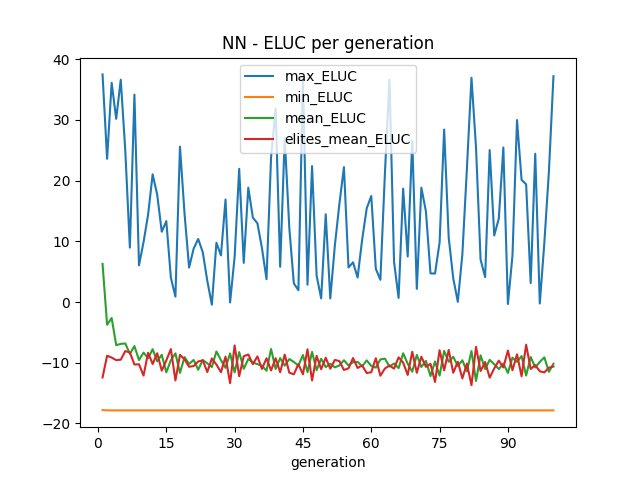

In [32]:
plot_file = os.path.join(experiment_results_dir, 'ELUC_plot.png')
Image(filename=plot_file)

### change

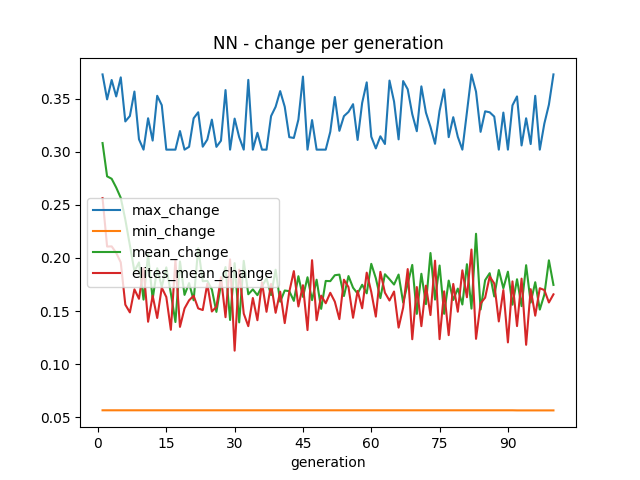

In [33]:
plot_file = os.path.join(experiment_results_dir, 'change_plot.png')
Image(filename=plot_file)

### Pareto front

In [34]:
FILTER = False

last_gen_filename = os.path.join(experiment_results_dir, str(len(stats_df)) + '.csv')
last_gen_df = pd.read_csv(last_gen_filename)
pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
# Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
pareto_df = pareto_df.sort_values(by='change', ascending=True)

if FILTER:
# Filtering
    remove = []
    for i in range(len(pareto_df)-1):
        if np.isclose(pareto_df['change'].iloc[i], pareto_df['change'].iloc[i+1], rtol=0.1) and not pareto_df['is_elite'].iloc[i+1]:
            remove.append(i+1)
    print(remove)
    print(len(pareto_df))
    pareto_df = pareto_df.drop(pareto_df.index[remove])
    print(len(pareto_df))
pareto_df

,id,identity,ELUC,NSGA-II_crowding_distance,NSGA-II_rank,change,is_elite
0,92_100,"{'ancestor_count': 2, 'ancestor_ids': ['67_93'...",-0.567555,inf,1,0.056491,True
12,100_13,"{'ancestor_count': 3, 'ancestor_ids': ['92_100...",-0.812389,0.095416,1,0.057435,False
82,100_83,"{'ancestor_count': 99, 'ancestor_ids': ['92_10...",-1.809912,0.097126,1,0.062260,False
36,100_37,"{'ancestor_count': 99, 'ancestor_ids': ['99_68...",-2.110223,0.054982,1,0.062837,False
52,100_53,"{'ancestor_count': 99, 'ancestor_ids': ['99_18...",-2.543192,0.111248,1,0.065338,False
77,100_78,"{'ancestor_count': 99, 'ancestor_ids': ['92_10...",-3.548319,0.137954,1,0.069712,True
79,100_80,"{'ancestor_count': 99, 'ancestor_ids': ['92_10...",-4.058870,0.088485,1,0.077665,False
95,100_96,"{'ancestor_count': 99, 'ancestor_ids': ['99_18...",-4.329879,0.093020,1,0.080326,False
35,100_36,"{'ancestor_count': 99, 'ancestor_ids': ['99_28...",-5.361600,0.134376,1,0.081989,True
57,100_58,"{'ancestor_count': 99, 'ancestor_ids': ['99_95...",-6.176937,0.098057,1,0.087067,False


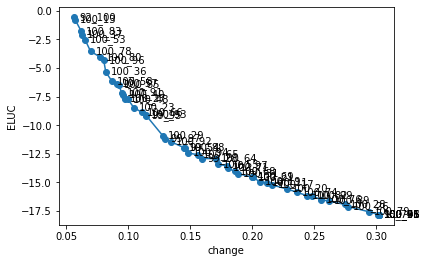

In [35]:
%matplotlib inline
fig, ax = plt.subplots()
pareto_df.plot(x='change',
               y='ELUC',
               marker='o',
               legend=False,
               ylabel='ELUC',
               ax=ax)
# Show the prescriptor id next to each point
for idx, row in pareto_df.iterrows():
    ax.annotate(row['id'],
               (row['change'], row['ELUC']),
               xytext=(5, -2),
               textcoords='offset points')


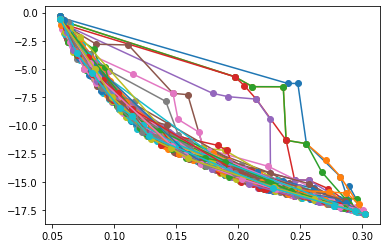

In [36]:
def plot_all_pareto():
    fig = plt.figure()
    for i in range(1, 101):
        gen_df = pd.read_csv(os.path.join(experiment_results_dir, f"{i}.csv"), header=0)
        gen_df = gen_df.sort_values(by="change")
        gen_df = gen_df[gen_df["is_elite"] == True]
        plt.plot(gen_df["change"], gen_df["ELUC"], label=f"{i}", marker="o")
    #plt.legend()
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([-28, 1])
    ax.patch.set_facecolor("white")
    #fig.savefig("../saved/pareto_short.jpg", bbox_inches="tight", transparent=False, facecolor=fig.get_facecolor())
    plt.show()

plot_all_pareto()

In [37]:
def get_pareto_df(gen):
    gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

In [38]:
gen_010_pareto_df = get_pareto_df(10)

In [39]:
# gens = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
gens = [1, 25, 50, 75, 100]
# gens = [1, 33, 66, 100]

In [40]:
def get_merged_df(gens):
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [41]:
merged_df = get_merged_df(gens)

In [42]:
def plot_gens(gens):
    merged_df = get_merged_df(gens)
    fig, ax = plt.subplots()
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)
        
        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       legend=False,
                       ylabel='ELUC',
                       ax=ax)
        

    plt.grid() 
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1, 2, 4, 3]
    plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    # plt.savefig("../saved/figure3a.pdf", format="pdf", dpi=300)

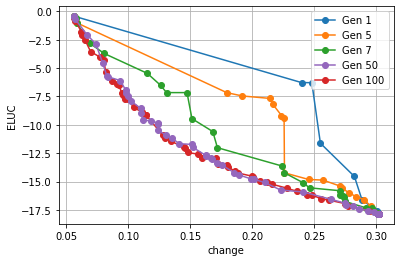

In [43]:
plot_gens([1, 5, 7, 100, 50])

In [44]:
all_gens = [a + 1 for a in range(100)]

In [45]:
def get_gen_df(gen):
    gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [46]:
all_gens_df = get_all_gens_df(all_gens)

<Axes: xlabel='change', ylabel='ELUC'>

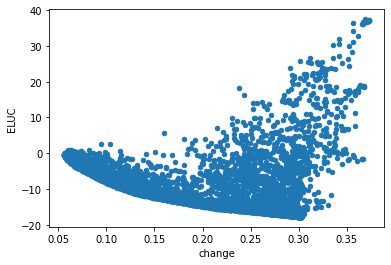

In [47]:
all_gens_df.plot.scatter(x='change', y='ELUC')

<Axes: xlabel='change', ylabel='ELUC'>

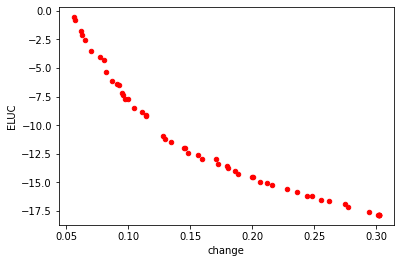

In [48]:
get_pareto_df(all_gens[-1]).plot.scatter(x='change', y='ELUC', c='red')

In [49]:
def plot_all_gens(gens):
    all_gens_df = get_all_gens_df(gens)
    fig, ax = plt.subplots()
    curve_names = []
    # for gen in gens:
        # curve_name = f"Gen {gen}"
        # curve_names.append(curve_name)
        # merged_df[merged_df["Name"] == curve_name].plot(x='change',
        #                y='ELUC',
        #                marker='o',
        #                legend=False,
        #                ylabel='ELUC',
        #                ax=ax)
    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax)
    # Plot last gen's pareto front in red
    get_pareto_df(all_gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax)
    plt.grid()
    # plt.savefig("../saved/figure3b.pdf", format="pdf", dpi=300) 
    # plt.legend(labels=curve_names, loc="upper right")

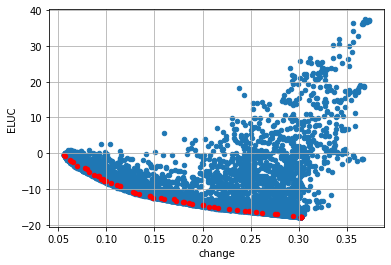

In [50]:
plot_all_gens(all_gens)

## Heuristic Experiment

In [51]:
def perfect_prescribe_row(row, reco_coefs, pct_change):
    best_col = reco_coefs[-1][0]
    max_change = min(row[RECO_COLS].sum() - row[best_col], pct_change)
    changed = 0
    for coef in reco_coefs:
        if not coef[0] == best_col: # This technically shouldn't be necessary
            # If we have more change left than there is in this column, delete it all
            if row[coef[0]] < max_change - changed:
                changed += row[coef[0]]
                row[coef[0]] = 0
            # Otherwise, remove however much change is left
            else:
                row[coef[0]] -= (max_change - changed)
                changed = max_change
                break
    row[best_col] += changed
    return row


def even_prescribe_row(row, pct_change, best_col):
    presc_cols = [col for col in RECO_COLS]
    presc_cols.remove(best_col)
    row_sum = row[presc_cols].sum()
    max_change = min(row_sum, pct_change)
    row[presc_cols] = row[presc_cols].apply(lambda col: col - (col/row_sum) * max_change if col - (col/row_sum) * max_change >= 0 else 0)
    row[best_col] = row[best_col] + max_change
    return row

In [52]:
def perfect_prescribe(context, pct_change, coefs):
    """
    Perfect prescription algorithm:
        1. Add to forest as much pct change as possible up to forest = 1
        2. Subtract from bottom up however much was changed
    """

    adjusted = context.copy()
    coefficients = zip(LAND_USE_COLS, coefs)
    reco_coefs = [coef for coef in coefficients if coef[0] in RECO_COLS]
    reco_coefs = sorted(reco_coefs, key=lambda x: x[1], reverse=True)
    adjusted = adjusted.apply(lambda row: perfect_prescribe_row(row, reco_coefs, pct_change), axis=1)
    return adjusted

def even_prescribe(context, pct_change, best_col):
    """
    Takes evenly from all columns and adds to best col
    """
    adjusted = context.copy()
    adjusted = adjusted.apply(lambda row: even_prescribe_row(row, pct_change, best_col), axis=1)
    return adjusted

In [53]:
whole_test_df = da_to_df(raw, start_year=TEST_YEAR, end_year=None, countries=COUNTRIES)
print(f"Test Size: {len(whole_test_df)}")
# TODO: change this if needed
TEST_PCT = 0.01
test_df = whole_test_df.sample(frac=TEST_PCT, random_state=100)
print(f"Test sample: {len(test_df)}")
test_df_encoded = encoder.encode_as_df(test_df.copy())
context_df = test_df[LAND_USE_COLS + ["cell_area"]]
encoded_context = test_df_encoded[LAND_USE_COLS + ["cell_area"]]

Test Size: 2420350
Test sample: 24204


In [54]:
dummy_prescriptor = UnileafPrescriptor(config,
                                   eval_df_encoded,
                                   encoder,
                                   all_predictors)

In [55]:
even_elucs = []
even_changes = []
for pct in tqdm([0.1 * i for i in range(1, 11)]):
    reco_df = even_prescribe(context=context_df, pct_change=pct, best_col="secdf")
    prescribed_actions_df = reco_df[RECO_COLS].reset_index(drop=True) - context_df[RECO_COLS].reset_index(drop=True)

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(RECO_MAP, axis=1)
    prescribed_actions_df[NO_CHANGE_COLS] = 0
    # Encode the diffs to match what the Predictor expects
    # Note: diffs are values between [-1, 1] and they are encoded between [0, 1]
    #encoded_prescribed_actions_df = data_encoder.encode_as_df(prescribed_actions_df[DIFF_RECO_COLS])
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df.reset_index(drop=True),
                                            prescribed_actions_df[DIFF_LAND_USE_COLS]],
                                            axis=1)
    
    prescribed_actions_df = context_actions_df[DIFF_LAND_USE_COLS]
    # Rename the columns to match what the predictor expects
    eluc = dummy_prescriptor.predict_eluc(context_actions_df).mean().iloc[0]
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[LAND_USE_COLS].sum(axis=1)).mean()
    
    even_elucs.append(eluc)
    even_changes.append(change)

print(even_elucs)
print(even_changes)

100%|██████████| 10/10 [01:49<00:00, 10.90s/it]

[-3.8449443838571558, -7.350809025102612, -10.582696509365299, -13.541761404970439, -16.238398772999282, -18.66553871070948, -20.79694505382472, -22.62751118465812, -24.11359739143628, -24.948051003908695]
[0.06551090741969573, 0.12407842187955882, 0.17823751628850137, 0.2284023690137293, 0.2746473985661265, 0.3167365619821988, 0.354206826943482, 0.38708233678981696, 0.41479510099492123, 0.4308408443110419]


In [56]:
coefs = superpredictor.models[-1].coef_

perfect_elucs = []
perfect_changes = []
for pct in tqdm([0.1 * i for i in range(1, 11)]):
    reco_df = perfect_prescribe(context=context_df, pct_change=pct, coefs=coefs)
    prescribed_actions_df = reco_df[RECO_COLS].reset_index(drop=True) - context_df[RECO_COLS].reset_index(drop=True)

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(RECO_MAP, axis=1)
    prescribed_actions_df[NO_CHANGE_COLS] = 0
    # Encode the diffs to match what the Predictor expects
    # Note: diffs are values between [-1, 1] and they are encoded between [0, 1]
    #encoded_prescribed_actions_df = data_encoder.encode_as_df(prescribed_actions_df[DIFF_RECO_COLS])
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df.reset_index(drop=True),
                                            prescribed_actions_df[DIFF_LAND_USE_COLS]],
                                            axis=1)
    
    prescribed_actions_df = context_actions_df[DIFF_LAND_USE_COLS]
    # Rename the columns to match what the predictor expects
    eluc = dummy_prescriptor.predict_eluc(context_actions_df).mean().iloc[0]
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[LAND_USE_COLS].sum(axis=1)).mean()
    
    perfect_elucs.append(eluc)
    perfect_changes.append(change)

print(perfect_elucs)
print(perfect_changes)

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

[-5.013439396939435, -9.091924281602617, -12.593572842726926, -15.598979898241453, -18.170031014507735, -20.309957094442353, -22.012553163632347, -23.324046731551572, -24.341062726141583, -24.948050738981514]
[0.06551090685281258, 0.12407842105239603, 0.17823751520388761, 0.22840236766115599, 0.2746473969468385, 0.31673656005769973, 0.35420682463561576, 0.38708233397607067, 0.4147950975107904, 0.4308408389647245]


In [57]:
from keras.models import load_model

def load_prescriptor(id):
    prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(len(stats_df)),
                                          id + '.h5')
    print(f'Loading prescriptor model: {prescriptor_model_filename}')
    prescriptor_model = load_model(prescriptor_model_filename, compile=False)
    return prescriptor_model

In [58]:
test_prescriptors = [load_prescriptor(id) for id in list(pareto_df["id"])]

Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/92_100.h5
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_13.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_83.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_37.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_53.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_78.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_80.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_96.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_36.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_58.h5
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_57.h5
Loadin

In [61]:
trained_elucs = []
trained_changes = []
i = 0
for id in pareto_df["id"].unique():
    trained_presc = load_prescriptor(id)
    reco_land_use = esp_evaluator.prescribe(trained_presc, encoded_context)
    # Reformat recommended land use to land diff
    reco_land_use_df = pd.DataFrame(reco_land_use["reco_land_use"].tolist(),
                                    columns=RECO_COLS)
    context_actions_df = reco_to_context_actions(reco_land_use_df, encoded_context, encoder)
    prescribed_actions_df = context_actions_df[DIFF_LAND_USE_COLS]
    eluc = dummy_prescriptor.predict_eluc(context_actions_df).mean().iloc[0]
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[LAND_USE_COLS].sum(axis=1)).mean()
    trained_elucs.append(eluc)
    trained_changes.append(change)

print(trained_elucs)
print(trained_changes)

Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/92_100.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_13.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_83.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_37.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_53.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_78.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained_prescriptors/NN/better_nn_noc4per/100/100_80.h5
757/757 [==============================] - 3s 3ms/step
Loading prescriptor model: trained

[-3.8449443838571558, -7.350809025102612, -10.582696509365299, -13.541761404970439, -16.238398772999282, -18.66553871070948, -20.79694505382472, -22.62751118465812, -24.11359739143628, -24.948051003908695]
[0.06551090741969573, 0.12407842187955882, 0.17823751628850137, 0.2284023690137293, 0.2746473985661265, 0.3167365619821988, 0.354206826943482, 0.38708233678981696, 0.41479510099492123, 0.4308408443110419]
[-5.013439396939435, -9.091924281602617, -12.593572842726926, -15.598979898241453, -18.170031014507735, -20.309957094442353, -22.012553163632347, -23.324046731551572, -24.341062726141583, -24.948050738981514]
[0.06551090685281258, 0.12407842105239603, 0.17823751520388761, 0.22840236766115599, 0.2746473969468385, 0.31673656005769973, 0.35420682463561576, 0.38708233397607067, 0.4147950975107904, 0.4308408389647245]
[0.12791433079824482, -0.1874195192679652, -1.622986370013324, -2.1571927687724695, -2.8963764570790422, -3.9851444651059675, -4.569980513982224, -4.908062401070739, -6.636

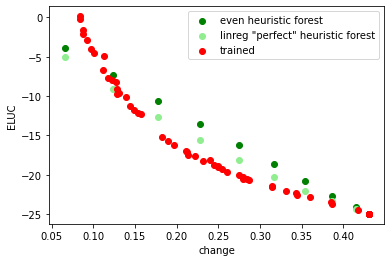

In [62]:
print(even_elucs)
print(even_changes)
print(perfect_elucs)
print(perfect_changes)
print(trained_elucs)
print(trained_changes)
print(dict(zip(DIFF_LAND_USE_COLS, coefs)))
plt.scatter(even_changes, even_elucs, color="green", label="even heuristic forest")
plt.scatter(perfect_changes, perfect_elucs, color="lightgreen", label="linreg \"perfect\" heuristic forest")
plt.scatter(trained_changes, trained_elucs, color="red", label="trained")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
# plt.savefig("../saved/figure4.pdf", format="pdf", dpi=300)
plt.show()